In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import albumentations as A
# from albumentations.pytorch import transforms
from copy import copy
from fastai2.vision.all import get_image_files, AdaptiveConcatPool2d, \
    aug_transforms, show_image, show_images, load_image, PoolFlatten, \
    PoolType
from itertools import zip_longest
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pytorch_lightning as pl
# from pytorch_lightning.logging.comet import CometLogger
# from pytorch_lightning.loggers import MLFlowLogger
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision as tv
import warnings

from htools import *
from img_wang.data import get_databunch, load_img
from img_wang.models import Unmixer, Encoder, StackedEncoder, MLPHead,\
    SimilarityHead, TorchvisionEncoder
from incendio.callbacks import MetricHistory
from incendio.core import Trainer
from img_wang.losses import ContrastiveLoss2d, PairwiseLossReduction
from img_wang.utils import summarize_acts
from incendio.optimizers import variable_lr_optimizer
from incendio.utils import init_bias_constant_

/Users/hmamin/pythonhm/htools/htools/core.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Counter, Sequence, Iterable, \
/Users/hmamin/anaconda3/lib/python3.7/site-packages/incendio/callbacks.py:25: UserWarning: Accio not available.
  warnings.warn('Accio not available.')


In [3]:
cd_root()

Current directory: /Users/hmamin/img_wang


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class UnmixerPL(pl.LightningModule):
    
    def __init__(self, net=None, loss=F.mse_loss):
        super().__init__()
        self.net = net or Unmixer()
        self.loss = loss
        
    def forward(self, *x):
        return self.net(*x)
    
    def training_step(self, batch, batch_i):
        *x, y = batch
        y_hat = self(*x)
        loss = self.loss(y_hat, y)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_i):
        *x, y = batch
        y_hat = self(*x)
        loss = self.loss(y_hat, y)
        res = pl.EvalResult(checkpoint_on=loss)
        res.log('val_loss', loss)
        return res
    
    def configure_optimizers(self):
        return variable_lr_optimizer(self.net)

In [ ]:
class MixupDataPL(pl.LightningDataModule):
    
    def __init__(self, dir_=None, paths=None,
                 mode:('mixup', 'scale', 'quadrant')='mixup', bs=32,
                 valid_bs_mult=1, train_pct=.9, shuffle_train=True,
                 drop_last=True, random_state=0, **ds_kwargs):
        self.dst, self.dsv, self.dlt, self.dlv = get_databunch(
            dir_, paths, mode, bs, valid_bs_mult, train_pct, shuffle_train,
            drop_last, random_state, **ds_kwargs
        )
        
    def train_dataloader(self):
        return self.dlt
    
    def val_dataloader(self):
        return self.dlv

In [4]:
dir_u = Path('data/imagewang-160/unsup/')

In [4]:
paths_xtiny = get_image_files(dir_u)[:4]
data = MixupDataPL(paths=paths_xtiny, mode='scale', bs=2, train_pct=.5, n=1)
module = UnmixerPL()

In [12]:
with open('/Users/hmamin/.comet.config', 'r') as f:
    comet_key = f.readlines()[-1].split('=')[-1].strip()
logger = CometLogger(api_key=comet_key, project_name='imagewang')

CometLogger will be initialized in online mode


In [13]:
mlf_logger = MLFlowLogger(experiment_name='debug-img-wang', 
                          tracking_uri='http://127.0.0.1:5000')

In [14]:
t = pl.Trainer(max_epochs=5, logger=mlf_logger, log_save_interval=1)
t.fit(module, data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type    | Params
---------------------------------
0 | net  | Unmixer | 394 K 


1

## Supervised Task

Try out the slightly more straightforward supervised task to see if that trains as expected with incendio and/or lightning. Trying to narrow down possible problems.

In [138]:
x = load_image('data/imagewang-160/train/n01440764/ILSVRC2012_val_00000293.jpeg')
x = np.array(x, dtype=np.float32)

In [8]:
class SupervisedDataPL(pl.LightningDataModule):
    
    def __init__(self, root='data/imagewang-160', bs=32, train_tfms=None,
                 val_tfms=None, shape=(128, 128)):
        """
        tfms: list[transform]
        """
        self.root = Path(root)
        self.bs = bs
        self.train_tfms = tv.transforms.Compose(
            train_tfms or 
            [tv.transforms.RandomResizedCrop(shape, (.9, 1.0)), 
             tv.transforms.RandomHorizontalFlip(),
             tv.transforms.RandomRotation(10),
             tv.transforms.ToTensor()]
        )
        self.val_tfms = tv.transforms.Compose(
            val_tfms or 
            [tv.transforms.Resize(shape),
             tv.transforms.ToTensor()])
        
    def setup(self, stage=''):
        self.ds_train = ImageFolder(self.root/'train', self.train_tfms)
        self.ds_val = ImageFolder(self.root/'val', self.val_tfms)
        self.ds_val.classes = self.ds_train.classes
        self.ds_val.class_to_idx = self.ds_train.class_to_idx
        self.dl_train = DataLoader(self.ds_train, self.bs, shuffle=True)
        self.dl_val = DataLoader(self.ds_val, self.bs)
        
    def train_dataloader(self):
        return self.dl_train
    
    def val_dataloader(self):
        return self.dl_val

In [9]:
class SupervisedEncoderClassifier(nn.Module):
    
    def __init__(self, enc=None, n_classes=20):
        super().__init__()
        self.n_classes = n_classes
        
        # Layers
        self.enc = enc or Encoder()
        self.pool = PoolFlatten('cat')
        # Concat pool doubles last feature dimension.
        self.fc = nn.Linear(list(self.enc.parameters())[-1].shape[0]*2,
                            n_classes)
        
    def forward(self, x):
        x = self.enc(x)
        x = self.pool(x)
        return self.fc(x).squeeze()

In [11]:
sdata = SupervisedDataPL(bs=2)
sdata.setup()

In [333]:
net = SupervisedEncoderClassifier()

In [334]:
x, y = next(iter(sdata.dl_train))
x.shape, y.shape

(torch.Size([2, 3, 128, 128]), torch.Size([2]))

In [336]:
yhat = net(x)
yhat.shape

torch.Size([2, 20])

In [340]:
yhat.dtype, y.dtype

(torch.float32, torch.int64)

In [351]:
module = UnmixerPL(net, loss=F.cross_entropy)

In [352]:
t = pl.Trainer(max_epochs=5, overfit_batches=1)
t.fit(module, sdata)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type                        | Params
-----------------------------------------------------
0 | net  | SupervisedEncoderClassifier | 404 K 


/Users/hmamin/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:22: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

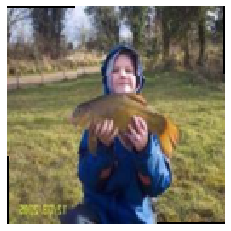

In [355]:
show_image(x[0])

In [356]:
with torch.no_grad():
    yhat = net(x)

In [360]:
F.softmax(yhat, dim=-1).argmax(-1)

tensor([18, 18])

In [361]:
y

tensor([0, 0])

## Incendio

Supervised problem. Finally works on small subset!

In [11]:
def ds_subset(ds, n, random=False, attr='samples'):
    ds = copy(ds)
    samples = getattr(ds, attr)
    setattr(ds, attr, [samples[i] for i in np.random.randint(0, len(ds), n)] \
            if random else samples[:n])
    return ds

In [26]:
dst = ds_subset(sdata.ds_train, 400, True)
dsv = ds_subset(sdata.ds_val, 40, True)
dst

Dataset ImageFolder
    Number of datapoints: 400
    Root location: data/imagewang-160/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(128, 128), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
           )

In [27]:
train_bs, val_bs = 8, 8
# No shuffling for debugging purposes.
dlt = DataLoader(dst, batch_size=train_bs, shuffle=False)
dlv = DataLoader(dsv, batch_size=val_bs, shuffle=False)

In [28]:
for i, (*x, y) in enumerate(dlt):
    print(smap(*x, y), y)
    if i > 3: break

[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([ 8, 18,  0, 16, 17,  0, 16, 16])
[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([ 2, 19,  7, 19, 13,  0, 15, 17])
[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([ 0, 15, 18,  0,  1, 15,  0, 17])
[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([15,  3, 19, 16, 13, 14, 17, 15])
[torch.Size([8, 3, 128, 128]), torch.Size([8])] tensor([16, 14,  8, 16, 19, 17, 16,  8])


In [29]:
net = SupervisedEncoderClassifier()

In [30]:
t = Trainer(net, dst, dsv, dlt, dlv, F.cross_entropy, 'multiclass', 
            'data/models/v0', callbacks=[MetricHistory(None, None)])

In [31]:
t.fit(10)

2020-08-23 00:52:15,208 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)




2020-08-23 00:52:17,320
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  3.0521 |       6.2169 |

=====




2020-08-23 00:52:18,914
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.6752 |       5.5996 |

=====




2020-08-23 00:52:20,198
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.5463 |       5.5759 |

=====




2020-08-23 00:52:21,721
 
=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.4247 |       5.2378 |

=====




2020-08-23 00:52:23,063
 
=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.3461 |       4.9975 |

=====




2020-08-23 00:52:24,374
 
=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.3110 |       4.6047 |

=====




2020-08-23 00:52:25,728
 
=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.2089 |       5.1317 |

=====




2020-08-23 00:52:27,294
 
=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.1145 |       4.8552 |

=====




2020-08-23 00:52:28,601
 
=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.0751 |       4.9417 |

=====




2020-08-23 00:52:29,978
 
=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.0398 |       4.6526 |

=====

2020-08-23 00:52:29,980
 Training complete. Model in eval mode.


TypeError: join() argument must be str or bytes, not 'NoneType'

In [442]:
# len(dst)=40, len(dsv)=4, bs_t=8, bs_v=4
# t.fit(10)

2020-08-15 23:15:18,657 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)




2020-08-15 23:15:20,367
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  3.5978 |       3.0423 |

=====




2020-08-15 23:15:22,601
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  2.0457 |       4.7251 |

=====




2020-08-15 23:15:24,867
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  1.5868 |       5.0436 |

=====




2020-08-15 23:15:27,515
 
=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  1.3469 |       4.7424 |

=====




2020-08-15 23:15:29,797
 
=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  1.1580 |       4.7005 |

=====




2020-08-15 23:15:31,752
 
=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  1.0070 |       5.0885 |

=====




2020-08-15 23:15:33,580
 
=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7909 |       4.7962 |

=====




2020-08-15 23:15:35,467
 
=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7043 |       4.5786 |

=====




2020-08-15 23:15:37,684
 
=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5834 |       6.2987 |

=====




2020-08-15 23:15:39,805
 
=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5468 |       5.8891 |

=====

2020-08-15 23:15:39,820
 Training complete. Model in eval mode.


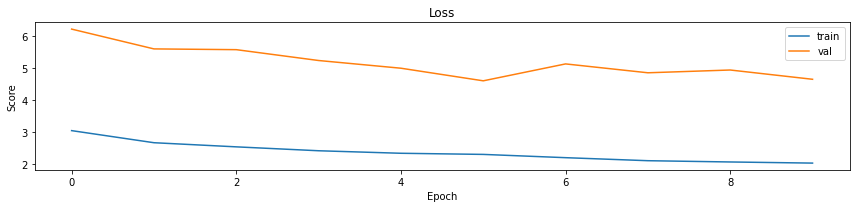

In [33]:
t.callbacks['MetricHistory'].plot()

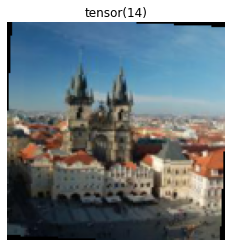

In [45]:
show_image(x[0][1], title=y[1])

In [51]:
net(x[0].to(t.device)).argmax(-1)

tensor([ 8, 14,  8, 17, 19, 17, 16,  0], device='cuda:0')

In [443]:
*x, y = next(iter(dlt))
smap(*x, y)

[torch.Size([8, 3, 128, 128]), torch.Size([8])]

In [444]:
y

tensor([14, 15,  8, 17, 14,  0,  1,  8])

In [446]:
F.softmax(net(*x), dim=-1).argmax(-1)

tensor([14, 15, 18, 15, 14,  0, 12,  8])

In [447]:
F.cross_entropy(net(*x), y)

tensor(1.0842, grad_fn=<NllLossBackward>)

## Incendio - Unsupervised Scale Dataset (multi-label classification)

Use new classification mode to try out scale dataset unsupervised task.

In [395]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup', mode='scale', 
                                   bs=3, train_pct=.5, max_train_len=6,
                                   max_val_len=6, regression=False)
lmap(len, dst, dsv, dlt, dlv)

[6, 6, 2, 2]

In [396]:
*x, y = dst[0]
smap(*x, y)

[torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3])]

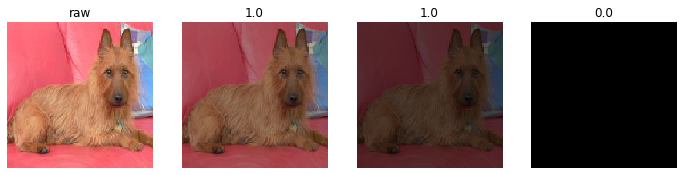

In [397]:
show_images(x, titles=['raw']+y.tolist())

In [398]:
*xb, yb = next(iter(dlt))
smap(*xb, yb)

[torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3])]

In [399]:
net = Unmixer(
    Encoder(),
    MLPHead(512, act=nn.LeakyReLU(), last_act=None)
)

/Users/hmamin/img_wang/lib/img_wang/models.py:200: UserWarning: Temperature is ignored when last activation is not softmax or log_softmax.
  warnings.warn('Temperature is ignored when last activation is '


In [400]:
net(*xb)

tensor([[-0.0134, -0.0873,  0.4267],
        [ 0.0632,  0.2780, -0.1175],
        [-0.0692, -0.0340, -0.1224]], grad_fn=<SqueezeBackward1>)

2020-09-01 21:28:38,392 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/hdmamin/img-wang/6c1d4d521f804cc6b1e4488d27c5d52c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [2] : (0.018207078622072003, 0.09494392251363024)
COMET INFO:     val_loss [2]   : (0.12326077977195382, 0.1694968929514289)
COMET INFO:   Parameters:
COMET INFO:     _stop_training : 1
COMET INFO:     epochs         : 10
COMET INFO:     eps            : 0.001
COMET INFO:     lr_mult        : 1.0
COMET INFO:     lrs            : 0.003
COMET INFO:     mode           : binary
COMET INFO:     out_dir        : data/models/v0
COMET INFO:     thresh         : 0.5
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     gi



=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.4062 |       0.9744 |





=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1536 |       1.2513 |





=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6301 |       1.0433 |





=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.0576 |       0.2549 |





=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.0535 |       0.0977 |





=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.0391 |       0.0431 |





=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.0187 |       0.0202 |





=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.0139 |       0.0126 |


Training complete. Model in eval mode.


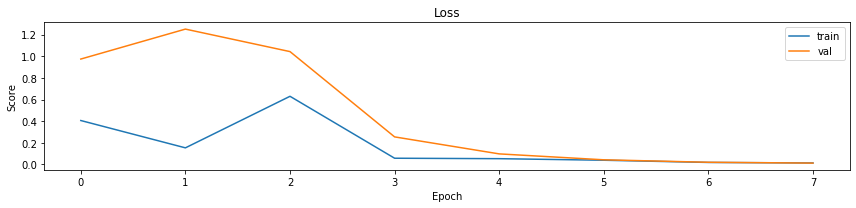

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/hdmamin/img-wang/e47c94c1c7a34ee8882cafd5e34fa5fe
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8] : (0.013887486420571804, 0.6301113832741976)
COMET INFO:     val_loss [8]   : (0.012599471490830183, 1.2512901425361633)
COMET INFO:   Parameters:
COMET INFO:     _stop_training : 1
COMET INFO:     epochs         : 8
COMET INFO:     eps            : 0.001
COMET INFO:     lr_mult        : 1.0
COMET INFO:     lrs            : 0.003
COMET INFO:     mode           : binary
COMET INFO:     out_dir        : data/models/v0
COMET INFO:     thresh         : 0.5
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (66 KB)
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 1
COMET INFO:

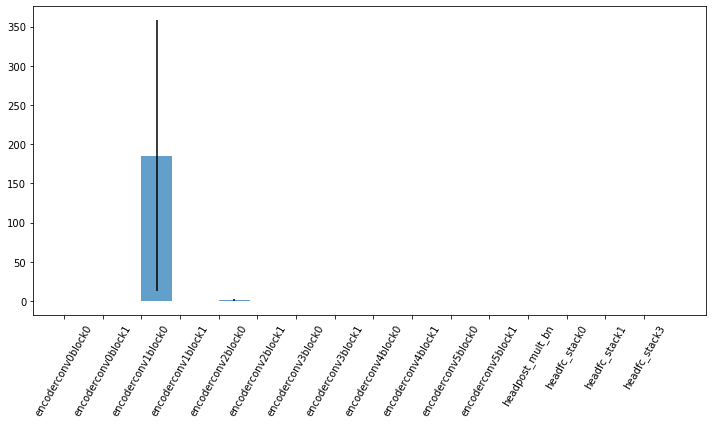

In [401]:
t = Trainer(net, dst, dsv, dlt, dlv, F.binary_cross_entropy_with_logits,
            'binary', 'data/models/v0', last_act=torch.sigmoid,
            callbacks=[MetricHistory(None, None),
                       CometCallbackWithGrads('img-wang')])
t.fit(8)

In [414]:
t.callbacks['CometCallbackWithGrads'].means

defaultdict(list,
            {'encoder.conv.0.block.0.weight': [0.053181056,
              0.011598949,
              0.022726893,
              0.016485432,
              0.02009983,
              0.006785574,
              0.005518154,
              0.006493324,
              0.03156315,
              0.0049779858,
              0.011039769,
              0.0014133754,
              0.0057545593,
              0.0018792924,
              0.0011651599,
              0.0009628846],
             'encoder.conv.0.block.1.weight': [0.02683602,
              0.0048763547,
              0.016478475,
              0.00854507,
              0.015153735,
              0.005778256,
              0.0056278585,
              0.010687305,
              0.033625253,
              0.0038942122,
              0.007006986,
              0.0010738268,
              0.0024191297,
              0.0018570896,
              0.0006847863,
              0.00078565103],
             'encoder.conv.1.block.0.we

In [402]:
torch.sigmoid(t.net(*map(lambda x: x.to(t.device), xb)))

tensor([[0.9603, 0.0129, 0.9596],
        [0.9954, 0.9998, 0.0197],
        [1.0000, 0.9964, 0.0263]], grad_fn=<SigmoidBackward>)

In [407]:
torch.sigmoid(t.predict(*xb, logits=True))

tensor([[0.9603, 0.0129, 0.9596],
        [0.9954, 0.9998, 0.0197],
        [1.0000, 0.9964, 0.0263]])

In [403]:
yb

tensor([[1., 0., 1.],
        [1., 1., 0.],
        [1., 1., 0.]])

In [408]:
res = t.validate(dlt)
np.mean(res['loss']), np.std(res['loss'])

(0.016288375947624445, 0.008359904866665602)

In [409]:
res = t.validate(dlv)
np.mean(res['loss']), np.std(res['loss'])

(0.042224015574902296, 0.030521113891154528)

In medium range run (~120 images in train set), some weird behavior: much higher train loss from validation method than during training. Pretty sure I didn't include dropout but should check. Maybe some batch norm wonkiness? This behavior is not occurring at the moment with tiny training set though.

## Incendio - Unsupervised Scale Dataset (regression)

Use new regression mode to try out scale dataset unsupervised task.

In [415]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup', mode='scale', 
                                   bs=3, train_pct=.5, max_train_len=3,
                                   max_val_len=3, regression=True)
lmap(len, dst, dsv, dlt, dlv)

[3, 3, 1, 1]

In [416]:
*x, y = dst[0]
smap(*x, y)

[torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3])]

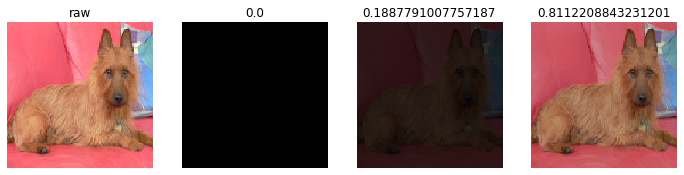

In [417]:
show_images(x, titles=['raw']+y.tolist())

In [418]:
*xb, yb = next(iter(dlt))
smap(*xb, yb)

[torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3])]

In [419]:
net = Unmixer(
    Encoder(fs=(16, 128), strides=(1, 1)),
    MLPHead(256, act=nn.LeakyReLU(), batch_norm=True, last_act='sigmoid')
)

# net = Unmixer(
#     Encoder(res_blocks=2),
#     MLPHead(512, last_act='sigmoid')
# )

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/hmamin/img_wang/lib/img_wang/models.py:200: UserWarning: Temperature is ignored when last activation is not softmax or log_softmax.
  warnings.warn('Temperature is ignored when last activation is '


In [420]:
net(*xb)

tensor([[0.5565, 0.3746, 0.3790],
        [0.3017, 0.5556, 0.2841],
        [0.3833, 0.2806, 0.5550]], grad_fn=<SigmoidBackward>)

In [421]:
yb

tensor([[0.0000, 0.4601, 0.5399],
        [0.5295, 0.0000, 0.4705],
        [0.5008, 0.4992, 0.0000]])

In [422]:
class PairwiseLossReduction(nn.Module):
    
    @valuecheck
    def __init__(self, reduce:('sum', 'mean', 'none')='mean', **kwargs):
        super().__init__()
        self.distance = nn.PairwiseDistance(**kwargs)
        self.reduce = identity if reduce == 'none' else getattr(torch, reduce)
        
    def forward(self, y_proba, y_true):
        return self.reduce(self.distance(y_proba, y_true))

In [423]:
PairwiseLossReduction('none')(net(*xb), yb)

tensor([0.5855, 0.6288, 0.6080], grad_fn=<NormBackward1>)

In [424]:
PairwiseLossReduction('mean')(net(*xb), yb)

tensor(0.6074, grad_fn=<MeanBackward0>)

2020-09-01 21:44:20,523 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/hdmamin/img-wang/754ca7c4e9064252a223881196e457cc





=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6373 |       0.4947 |





=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6832 |       0.4494 |





=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6044 |       0.5727 |





=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5301 |       0.5942 |





=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5383 |       0.5759 |





=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.4268 |       0.5836 |





=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.4288 |       0.5206 |





=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.3747 |       0.4779 |





=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2426 |       0.3303 |





=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.3703 |       0.2540 |


Training complete. Model in eval mode.


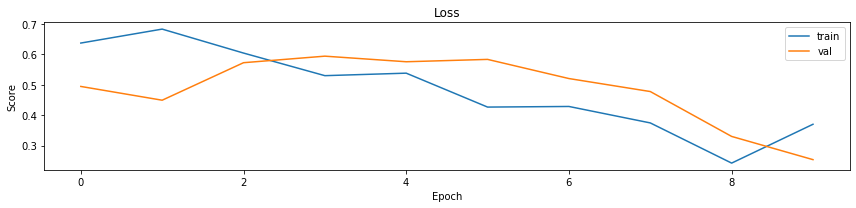

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/hdmamin/img-wang/754ca7c4e9064252a223881196e457cc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10] : (0.24259348213672638, 0.6832178235054016)
COMET INFO:     val_loss [10]   : (0.2539505958557129, 0.5942270755767822)
COMET INFO:   Parameters:
COMET INFO:     _stop_training : 1
COMET INFO:     epochs         : 10
COMET INFO:     eps            : 0.001
COMET INFO:     lr_mult        : 1.0
COMET INFO:     lrs            : 0.003
COMET INFO:     mode           : regression
COMET INFO:     out_dir        : data/models/v0
COMET INFO:     thresh         : 0.5
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (68 KB)
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 1
COMET I

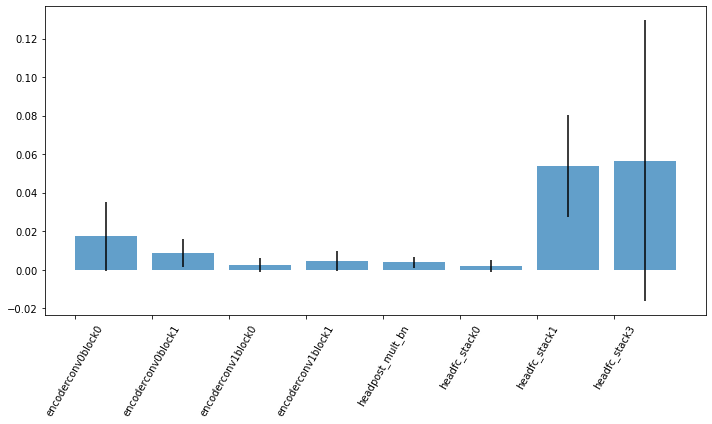

In [425]:
t = Trainer(net, dst, dsv, dlt, dlv, PairwiseLossReduction(),
            'regression', 'data/models/v0', 
            callbacks=[MetricHistory(None, None),
                       CometCallbackWithGrads('img_wang')])
t.fit(10)

In [426]:
t.predict(*xb)

tensor([[0.0085, 0.5172, 0.7299],
        [0.7199, 0.0102, 0.6053],
        [0.6022, 0.5409, 0.0091]])

In [427]:
yb

tensor([[0.0000, 0.4601, 0.5399],
        [0.5295, 0.0000, 0.4705],
        [0.5008, 0.4992, 0.0000]])

In [132]:
net.weight_stats()

[(0.007, 0.108),
 (1.002, 0.008),
 (0.006, 0.015),
 (-0.002, 0.069),
 (1.001, 0.011),
 (0.004, 0.011),
 (-0.0, 0.035),
 (1.0, 0.007),
 (0.001, 0.015),
 (-0.003, 0.037),
 (-0.004, 0.039),
 (0.996, 0.004),
 (0.027, 0.006),
 (-0.024, 0.034),
 (0.005, nan)]

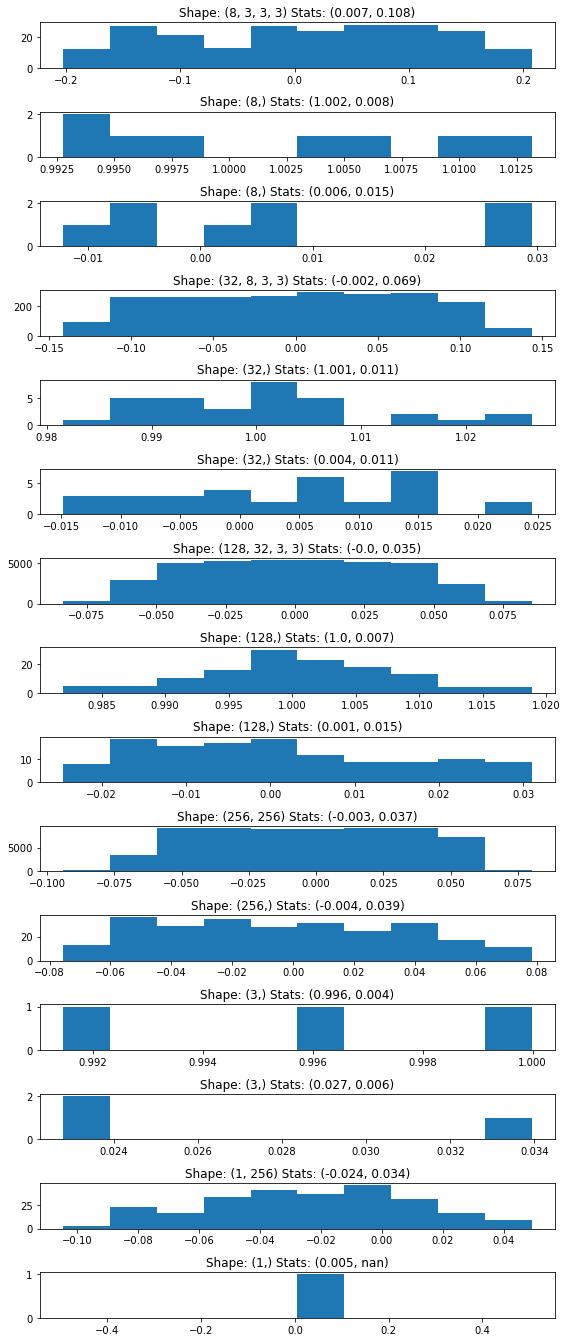

In [133]:
# Before adding batch norm, weights looked pretty uniform, now more normal.
# I think that may be a positive step (at least SOME learning is happening).
net.plot_weights()

In [26]:
loss = PairwiseLossReduction()
for *xb, yb in dlt:
    ypred = t.net(*map(lambda x: x.to(t.device), xb))
    print(ypred)
    print(yb)
    print(loss(ypred, yb.to(t.device)))
    print(spacer())

## Incendio - Unsupervised Scale Dataset (regression - random noise)

Use new regression mode to try out scale dataset unsupervised task.

In [428]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup', mode='scale', 
                                   bs=3, train_pct=.5, max_train_len=3,
                                   max_val_len=3, regression=True, noise=True)
lmap(len, dst, dsv, dlt, dlv)

[3, 3, 1, 1]

In [429]:
*x, y = dst[0]
smap(*x, y)

[torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3])]

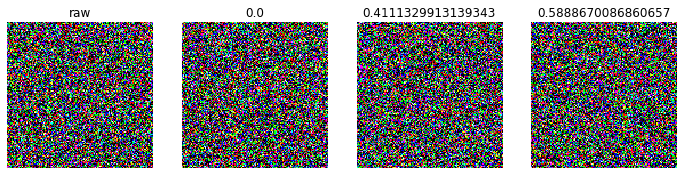

In [430]:
show_images(x, titles=['raw']+y.tolist())

In [431]:
*xb, yb = next(iter(dlt))
smap(*xb, yb)

[torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3, 128, 128]),
 torch.Size([3, 3])]

In [433]:
net = Unmixer(
    Encoder(fs=(8, 32, 128), strides=(1, 1, 1)),
    MLPHead(256, act=nn.LeakyReLU(), last_act='sigmoid', batch_norm=True)
)

# net = Unmixer(
#     Encoder(res_blocks=2),
#     MLPHead(512, last_act='sigmoid')
# )

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/hmamin/img_wang/lib/img_wang/models.py:200: UserWarning: Temperature is ignored when last activation is not softmax or log_softmax.
  warnings.warn('Temperature is ignored when last activation is '


In [434]:
net(*xb)

tensor([[0.3736, 0.3705, 0.3847],
        [0.3976, 0.4047, 0.3672],
        [0.3687, 0.3865, 0.3817]], grad_fn=<SigmoidBackward>)

In [435]:
yb

tensor([[0.0000, 0.6009, 0.3991],
        [0.5914, 0.4086, 0.0000],
        [0.3401, 0.0000, 0.6599]])

2020-09-01 21:47:35,386 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/hdmamin/img-wang/9eb17425459f49a8b74a05383658012d





=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.4268 |       0.4651 |





=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6699 |       0.5121 |





=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7197 |       0.4919 |





=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6947 |       0.4666 |





=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6335 |       0.4522 |





=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5997 |       0.4361 |





=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.4948 |       0.5039 |





=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5139 |       0.5107 |


Training complete. Model in eval mode.


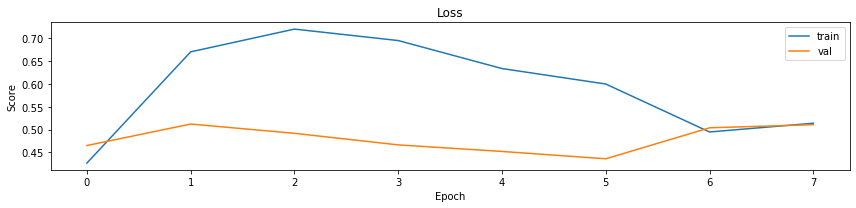

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/hdmamin/img-wang/9eb17425459f49a8b74a05383658012d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8] : (0.4267512857913971, 0.7196910381317139)
COMET INFO:     val_loss [8]   : (0.43614447116851807, 0.5121398568153381)
COMET INFO:   Parameters:
COMET INFO:     _stop_training : 1
COMET INFO:     epochs         : 8
COMET INFO:     eps            : 0.001
COMET INFO:     lr_mult        : 1.0
COMET INFO:     lrs            : 0.003
COMET INFO:     mode           : regression
COMET INFO:     out_dir        : data/models/v0
COMET INFO:     thresh         : 0.5
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (69 KB)
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 1
COMET INFO

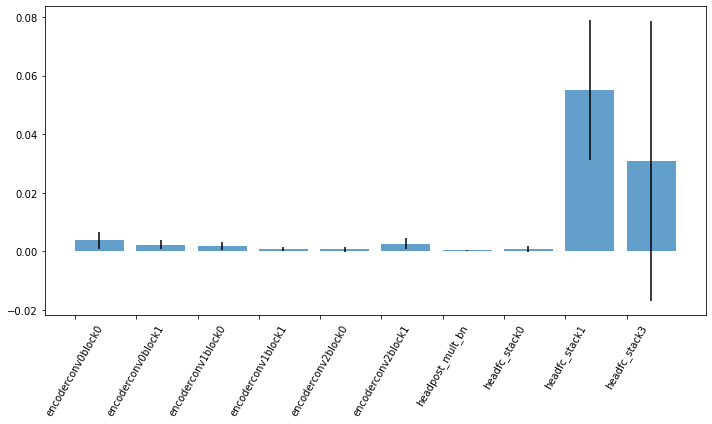

In [436]:
t = Trainer(net, dst, dsv, dlt, dlv, PairwiseLossReduction(),
            'regression', 'data/models/v0', 
            callbacks=[MetricHistory(None, None),
                       CometCallbackWithGrads('img-wang')])
t.fit(8)

In [56]:
t.net(*map(lambda x: x.to(t.device), xb))

tensor([[6.7811e-31, 3.6327e-31, 2.5796e-29],
        [1.6105e-29, 3.0592e-29, 6.0782e-30],
        [1.3493e-30, 1.2760e-30, 9.6403e-32]], grad_fn=<SigmoidBackward>)

In [57]:
yb

tensor([[0.4281, 0.5719, 0.0000],
        [0.4802, 0.0000, 0.5198],
        [0.4100, 0.0000, 0.5900]])

In [62]:
t.net.head.fc_stack[-1].bias

Parameter containing:
tensor([0.0135], requires_grad=True)

(array([15., 17., 37., 30., 37., 25., 26., 38., 23.,  8.]),
 array([-0.07412421, -0.05939869, -0.04467317, -0.02994765, -0.01522213,
        -0.00049661,  0.01422891,  0.02895443,  0.04367995,  0.05840547,
         0.07313099], dtype=float32),
 <a list of 10 Patch objects>)

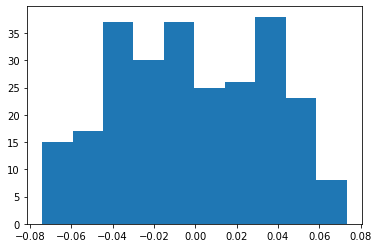

In [66]:
plt.hist(t.net.head.fc_stack[-1].weight.flatten().detach().numpy())

In [91]:
# Bias needs to be huge before net starts predicting > ~0.
init_bias_constant_(t.net.head.fc_stack[-1], 67)
t.net.head.fc_stack[-1].bias

Parameter containing:
tensor([67.], requires_grad=True)

In [92]:
t.net(*map(lambda x: x.to(t.device), xb))

tensor([[0.0773, 0.0430, 0.7612],
        [0.6655, 0.7908, 0.4289],
        [0.1429, 0.1362, 0.0118]], grad_fn=<SigmoidBackward>)

In [114]:
t = Trainer(net, dst, dsv, dlt, dlv, PairwiseLossReduction(),
            'regression', 'data/models/v0', callbacks=[MetricHistory(None, None)])
t.fit(25, 3e-3)

In [33]:
net.weight_stats()

[(-0.004, 0.112),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.002, 0.068),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.034),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.036),
 (0.002, 0.036),
 (-0.004, 0.034),
 (-0.019, nan)]

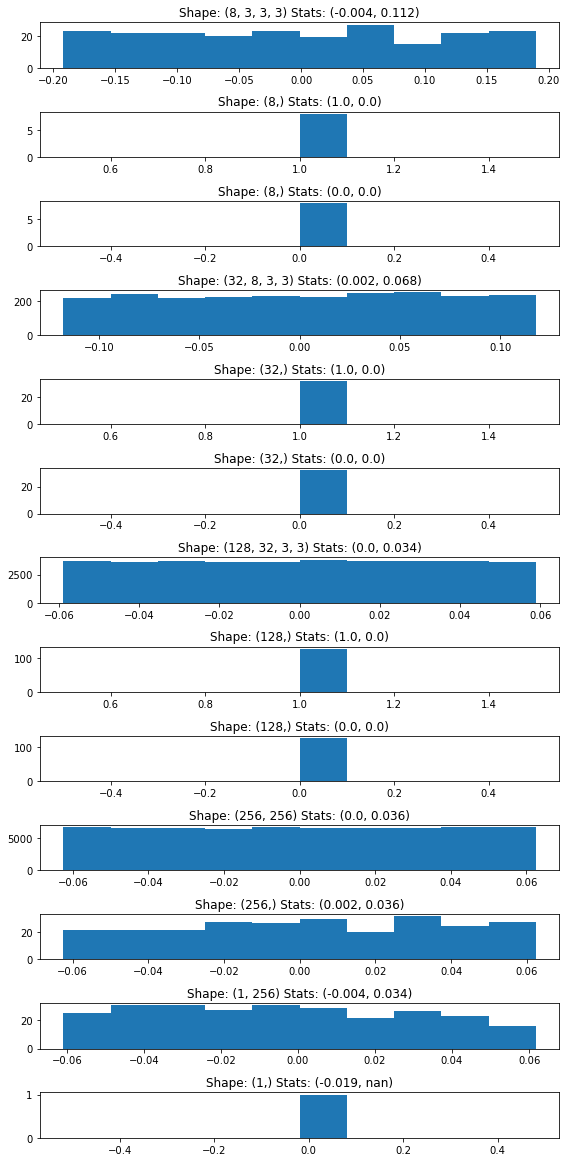

In [34]:
net.plot_weights()

In [26]:
loss = PairwiseLossReduction()
for *xb, yb in dlt:
    ypred = t.net(*map(lambda x: x.to(t.device), xb))
    print(ypred)
    print(yb)
    print(loss(ypred, yb.to(t.device)))
    print(spacer())

Looks like net predicts near zero for everything.

## Mixup Dataset (multi-label classification) - duplicate mode

Test out new trivial duplicate task to debug network/dataset/train loop.

In [78]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup', mode='mixup', 
                                   bs=2, train_pct=.5, max_train_len=4,
                                   max_val_len=4, regression=False, 
                                   debug_mode='dup_src')
lmap(len, dst, dsv, dlt, dlv)

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[2, 2, 1, 1]

In [79]:
*x, y = dst[0]
smap(*x, y)

[torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3])]

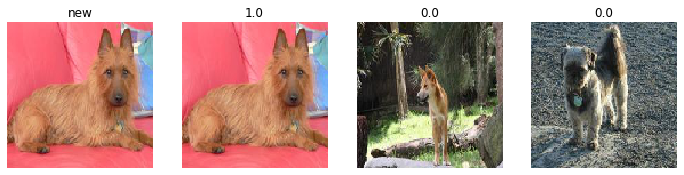

In [80]:
# dup_src mode
show_images(x, titles=['new']+y.tolist())

In [83]:
*xb, yb = next(iter(dlt))
smap(*xb, yb)

[torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3])]

In [174]:
# net = Unmixer(
#     Encoder(fs=(16, 256), strides=(1, 1), act=nn.LeakyReLU()),
#     MLPHead(512, act=nn.LeakyReLU(), batch_norm=False, 
#             post_mult_batch_norm=False, last_act=None, ds_n=3)
# )

# net = Unmixer(
#     TorchvisionEncoder(),
#     MLPHead(2_560, fs=(1024, 128, 1), act=nn.LeakyReLU(), batch_norm=False, 
#             post_mult_batch_norm=False, last_act=None, ds_n=3)
# )

net = Unmixer(
    TorchvisionEncoder(),
    SimilarityHead(last_act=None)
)

In [175]:
net.encoder.freeze()

In [176]:
net(*xb)

tensor([[-0.0632, -0.1691, -0.2932],
        [-0.0682, -0.1583, -0.2847]], grad_fn=<AddmmBackward>)

2020-09-03 22:38:17,327 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.01
    weight_decay: 0
)


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/hdmamin/img-wang/5b66c5e448a943caafde95b798409aae





=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6498 |       0.8601 |





=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7488 |       0.7513 |





=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7641 |       0.5616 |





=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5638 |       0.5080 |





=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8287 |       0.5860 |





=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6594 |       0.6152 |





=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6625 |       0.5670 |





=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6547 |       0.5800 |





=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7144 |       0.5898 |





=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6234 |       0.6080 |


Training complete. Model in eval mode.


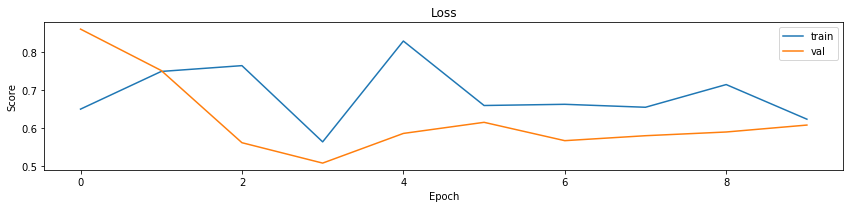

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/hdmamin/img-wang/5b66c5e448a943caafde95b798409aae
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10] : (0.5638377666473389, 0.8287085890769958)
COMET INFO:     val_loss [10]   : (0.5080420970916748, 0.8600719571113586)
COMET INFO:   Parameters:
COMET INFO:     _stop_training : 1
COMET INFO:     epochs         : 10
COMET INFO:     eps            : 0.001
COMET INFO:     lr_mult        : 1.0
COMET INFO:     lrs            : 0.01
COMET INFO:     mode           : binary
COMET INFO:     out_dir        : data/models/v0
COMET INFO:     thresh         : 0.5
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (24 KB)
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 1
COMET INFO:  

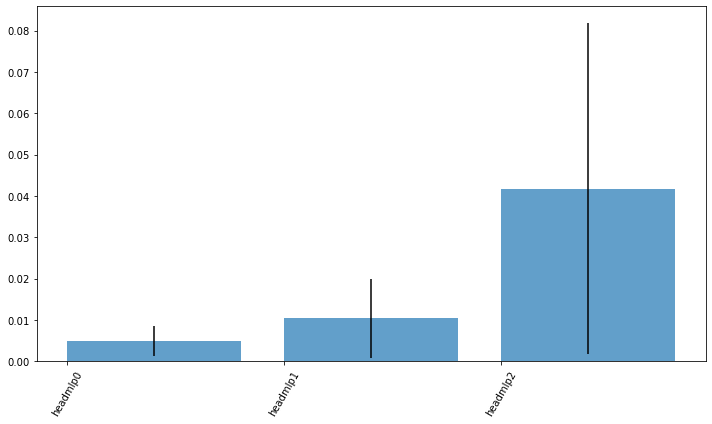

In [177]:
t = Trainer(net, dst, dsv, dlt, dlv, 
            F.binary_cross_entropy_with_logits,
            'binary', 'data/models/v0',
            callbacks=[MetricHistory(None, None),
                       CometCallbackWithGrads('img-wang')],
            last_act=torch.sigmoid)
t.fit(10, 1e-2)

In [178]:
t.predict(*xb, logits=False)

tensor([[0.3198, 0.3089, 0.4972],
        [0.3305, 0.3201, 0.4984]])

In [179]:
t.predict(*xb, logits=True)

tensor([[-0.7548, -0.8054, -0.0110],
        [-0.7060, -0.7534, -0.0065]])

In [180]:
yb

tensor([[1., 0., 0.],
        [1., 0., 0.]])

In [181]:
zs = [t.net.pool(t.net.encoder.predict(xb_[:1])) for xb_ in xb]

for z in zs:
    print(z[0, :5])
    print(F.cosine_similarity(zs[0], z, dim=1))
    mult = zs[0] * z
    print(mult[0, :5])
    print(mult.sum())
    print()

tensor([0.0000, 1.5956, 1.6321, 2.3009, 2.3027])
tensor([1.])
tensor([0.0000, 2.5459, 2.6636, 5.2940, 5.3024])
tensor(18003.4102)

tensor([0.0000, 1.5956, 1.6321, 2.3009, 2.3027])
tensor([1.])
tensor([0.0000, 2.5459, 2.6636, 5.2940, 5.3024])
tensor(18003.4102)

tensor([0.0000, 3.9885, 0.3818, 0.3770, 0.0000])
tensor([0.5330])
tensor([0.0000, 6.3639, 0.6231, 0.8674, 0.0000])
tensor(4993.6016)

tensor([0.0000, 0.0000, 1.1822, 0.0000, 0.0000])
tensor([0.4891])
tensor([0.0000, 0.0000, 1.9295, 0.0000, 0.0000])
tensor(4750.1846)



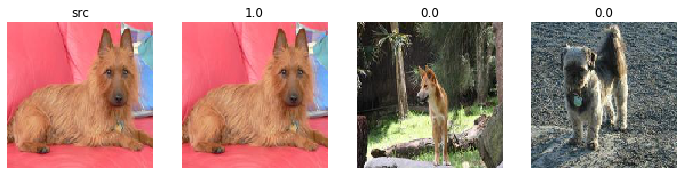

In [157]:
show_images([col[0] for col in xb], titles=['src']+y.tolist())

In [158]:
zs2 = [t.net.pool(t.net.encoder.predict(xb_[1:])) for xb_ in xb]

for z in zs2:
    print(z[0, :5])
    print(F.cosine_similarity(zs2[0], z, dim=1))
    mult = zs2[0] * z
    print(mult[0, :5])
    print(mult.sum())
    print()

tensor([0.0000, 3.5260, 0.4837, 0.3326, 0.1365])
tensor([1.])
tensor([ 0.0000, 12.4324,  0.2340,  0.1106,  0.0186])
tensor(4421.3770)

tensor([0.0000, 3.5260, 0.4837, 0.3326, 0.1365])
tensor([1.])
tensor([ 0.0000, 12.4324,  0.2340,  0.1106,  0.0186])
tensor(4421.3770)

tensor([0.0000, 0.0590, 1.2003, 0.0000, 0.0000])
tensor([0.4174])
tensor([0.0000, 0.2081, 0.5806, 0.0000, 0.0000])
tensor(2022.9072)

tensor([0.1213, 0.4614, 3.9644, 0.5404, 3.7114])
tensor([0.4457])
tensor([0.0000, 1.6269, 1.9178, 0.1797, 0.5065])
tensor(2136.0295)



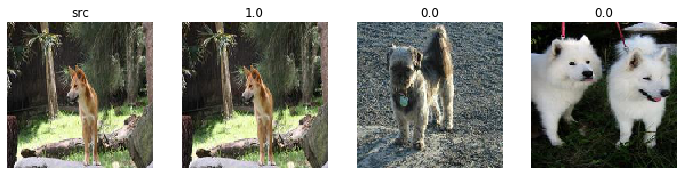

In [159]:
show_images([col[1] for col in xb], titles=['src']+y.tolist())

## Incendio - Unsupervised Mixup Dataset (multi-label classification)

Use new classification mode to try out scale dataset unsupervised task.

In [459]:
def summarize_acts(acts):
    print(acts.shape)
    flat = acts.flatten().detach().numpy()
    q = np.arange(0, 1.01, .1)
    print('% > 0:', (flat > 0).mean())
    pd.Series(flat).rename('quantiles').quantile(q).pprint()

    plt.hist(flat)
    plt.show()

In [460]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup', mode='mixup', 
                                   bs=2, train_pct=.5, max_train_len=4,
                                   max_val_len=4, regression=False)
lmap(len, dst, dsv, dlt, dlv)

[2, 2, 1, 1]

In [461]:
*x, y = dst[0]
smap(*x, y)

[torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3])]

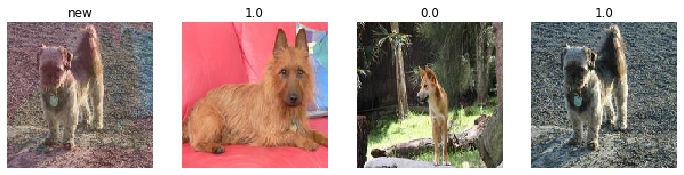

In [462]:
show_images(x, titles=['new']+y.tolist())

In [463]:
*xb, yb = next(iter(dlt))
smap(*xb, yb)

[torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3])]

In [489]:
# net = Unmixer(
#     Encoder(fs=(16, 256), strides=(1, 1), act=nn.LeakyReLU()),
#     MLPHead(512, act=nn.LeakyReLU(), batch_norm=False, post_mult_batch_norm=False, last_act=None, ds_n=3)
# )

# Note: mobilenet uses relu on last layer so def need some batch norm or acts
# will be huge. 1280 channel outputs from encoder.
net = Unmixer(
    TorchvisionEncoder(pretrained=True),
    MLPHead(2560, act=nn.LeakyReLU(), last_act=None, batch_norm=False, 
            post_mult_batch_norm=True, ds_n=3)
)

# net = Unmixer(
#     Encoder(fs=(256,), strides=(2,), act=nn.LeakyReLU()),
#     SimilarityHead(last_act=None)
# )

In [490]:
net(*xb)

tensor([[-0.1922, -0.2447, -0.0752],
        [-0.1126,  0.0074, -0.0767]], grad_fn=<SqueezeBackward1>)

In [491]:
# Toying with encoder that process whole batch at once. On hold for now.
# senc = StackedEncoder()
# senc(*xb).shape
# PoolFlatten('cat')(senc(*xb)).shape
# net.pool(net.encoder(xb[0])).shape
# senc(*xb).shape

torch.Size([2, 1280, 4, 4])
% > 0: 0.4548583984375


,quantiles
0.0,0.000000
0.1,0.000000
0.2,0.000000
0.3,0.000000
0.4,0.000000
0.5,0.000000
0.6,0.233358
0.7,0.688945
0.8,1.191457
0.9,1.840545


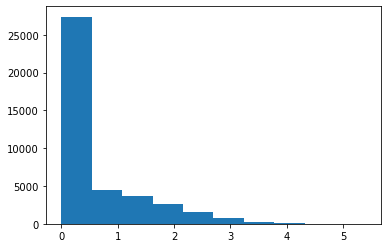

In [492]:
act = net.encoder(xb[0])
summarize_acts(act)

2020-09-01 22:04:48,359 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 1e-05
    weight_decay: 0
)


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/hdmamin/img-wang/d46b4fefdf374d01aed9005dc63c522f





=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7602 |       0.7328 |





=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7196 |       0.7323 |





=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7169 |       0.6989 |





=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.7380 |       0.6932 |





=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6838 |       0.6926 |





=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6467 |       0.7234 |





=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6053 |       0.7356 |





=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6814 |       0.7277 |





=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6797 |       0.7256 |





=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.6143 |       0.6763 |


Training complete. Model in eval mode.


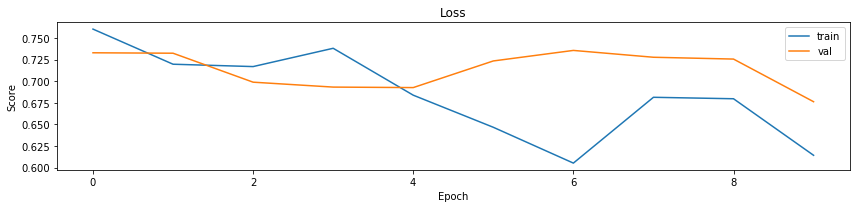

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/hdmamin/img-wang/d46b4fefdf374d01aed9005dc63c522f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10] : (0.605305552482605, 0.7602121829986572)
COMET INFO:     val_loss [10]   : (0.676273763179779, 0.7355621457099915)
COMET INFO:   Parameters:
COMET INFO:     _stop_training : 1
COMET INFO:     epochs         : 10
COMET INFO:     eps            : 0.001
COMET INFO:     lr_mult        : 1.0
COMET INFO:     lrs            : 1e-05
COMET INFO:     mode           : binary
COMET INFO:     out_dir        : data/models/v0
COMET INFO:     thresh         : 0.5
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (81 KB)
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 1
COMET INFO:   

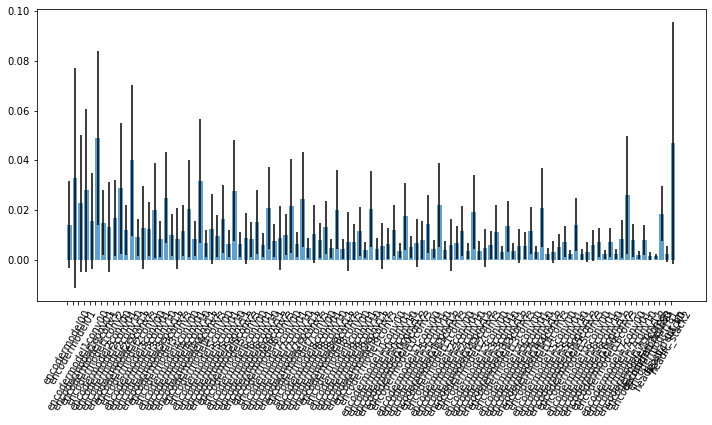

In [493]:
t = Trainer(net, dst, dsv, dlt, dlv, 
            F.binary_cross_entropy_with_logits,
            'binary', 'data/models/v0',
            callbacks=[MetricHistory(None, None),
                       CometCallbackWithGrads('img-wang')],
            last_act=torch.sigmoid)
t.fit(10, 1e-5)

In [494]:
t.predict(*xb, logits=False)

tensor([[0.5510, 0.4889, 0.5365],
        [0.4662, 0.5334, 0.5053]])

In [495]:
yb

tensor([[0., 1., 1.],
        [1., 1., 0.]])

**IN PROGRESS**
Trying to determine why activations are all positive after training.

torch.Size([2, 256, 124, 124])
% > 0: 0.5083745823442378


,quantiles
0.0,-0.041801
0.1,-0.009273
0.2,-0.006686
0.3,-0.004395
0.4,-0.002106
0.5,0.019268
0.6,0.247001
0.7,0.470750
0.8,0.694004
0.9,0.940619


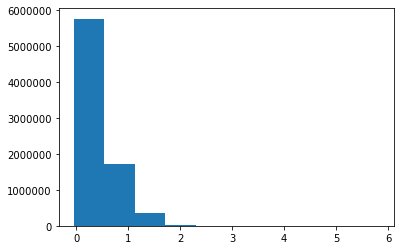

torch.Size([2, 256, 124, 124])
% > 0: 0.51548857594628


,quantiles
0.0,-0.080596
0.1,-0.011224
0.2,-0.007732
0.3,-0.004815
0.4,-0.002150
0.5,0.039499
0.6,0.282934
0.7,0.515011
0.8,0.775385
0.9,1.103602


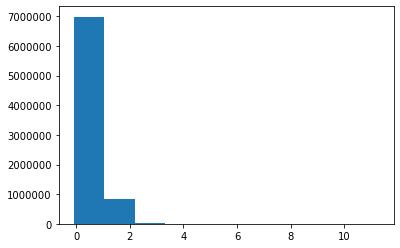

torch.Size([2, 256, 124, 124])
% > 0: 0.5075843644315817


,quantiles
0.0,-0.080596
0.1,-0.011436
0.2,-0.007845
0.3,-0.004979
0.4,-0.002383
0.5,0.019584
0.6,0.277244
0.7,0.535411
0.8,0.804344
0.9,1.128107


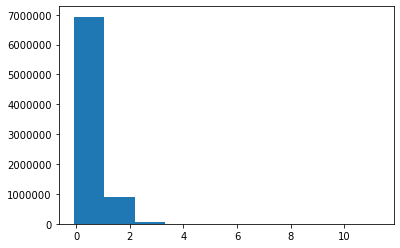

torch.Size([2, 256, 124, 124])
% > 0: 0.5070192335051379


,quantiles
0.0,-0.080789
0.1,-0.013514
0.2,-0.008979
0.3,-0.005624
0.4,-0.002680
0.5,0.020285
0.6,0.314626
0.7,0.603896
0.8,0.902405
0.9,1.307592


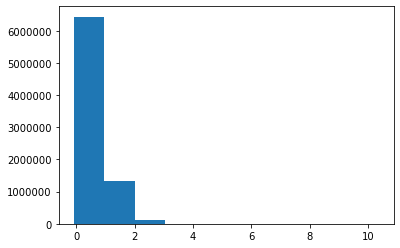

In [38]:
acts = [t.net.encoder.predict(xb_) for xb_ in xb]
for act in acts:
    summarize_acts(act)

torch.Size([2, 512])
% > 0: 1.0


,quantiles
0.0,0.014670
0.1,0.086343
0.2,0.179278
0.3,0.362725
0.4,0.529303
0.5,1.044100
0.6,1.642579
0.7,1.913120
0.8,2.166026
0.9,2.679367


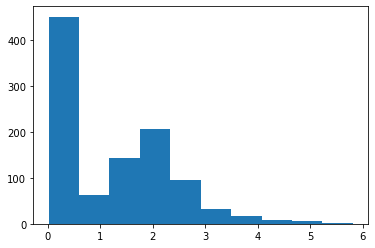

torch.Size([2, 512])
% > 0: 0.9951171875


,quantiles
0.0,-0.009617
0.1,0.108595
0.2,0.240260
0.3,0.403587
0.4,0.608198
0.5,1.184188
0.6,1.877406
0.7,2.360758
0.8,2.907881
0.9,3.854500


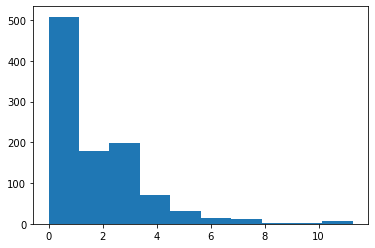

torch.Size([2, 512])
% > 0: 1.0


,quantiles
0.0,0.045314
0.1,0.167050
0.2,0.269645
0.3,0.413956
0.4,0.585232
0.5,1.077009
0.6,2.130062
0.7,2.543430
0.8,3.132414
0.9,4.161349


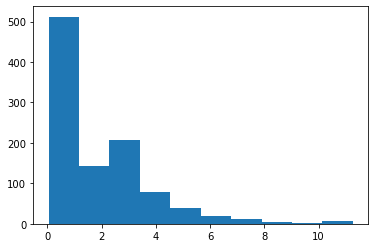

torch.Size([2, 512])
% > 0: 1.0


,quantiles
0.0,0.045314
0.1,0.163429
0.2,0.336740
0.3,0.444074
0.4,0.622126
0.5,1.200858
0.6,2.122816
0.7,2.608196
0.8,3.194971
0.9,4.119156


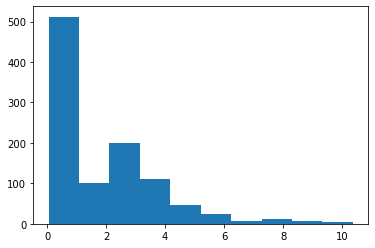

In [39]:
acts = [t.net.pool(act) for act in acts]
for act in acts:
    summarize_acts(act)

In [40]:
act1 = acts[0]
act2 = torch.stack(acts[1:], dim=1)

torch.Size([2, 3, 512])
% > 0: 0.9983723958333334


,quantiles
0.0,-0.001552
0.1,0.015874
0.2,0.043294
0.3,0.124882
0.4,0.277277
0.5,1.251481
0.6,3.443421
0.7,4.714992
0.8,6.518230
0.9,10.639845


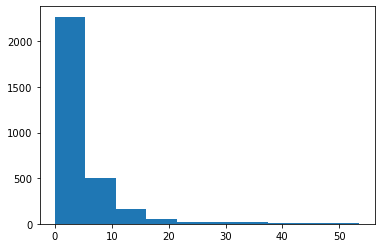

In [41]:
act = act1[:, None, ...] * act2
summarize_acts(act)

torch.Size([2, 3, 512])
% > 0: 0.19986979166666666


,quantiles
0.0,-0.507342
0.1,-0.501046
0.2,-0.490874
0.3,-0.481244
0.4,-0.471760
0.5,-0.419075
0.6,-0.235261
0.7,-0.143961
0.8,-0.000323
0.9,0.299695


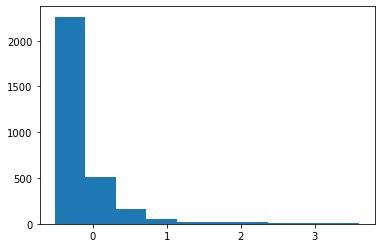

In [42]:
act = t.net.head.post_mult_bn(act)
summarize_acts(act)

Linear
torch.Size([2, 3, 256])
% > 0: 0.201171875


,quantiles
0.0,-2.934501
0.1,-1.736615
0.2,-1.434417
0.3,-1.180393
0.4,-0.938863
0.5,-0.693342
0.6,-0.502160
0.7,-0.268944
0.8,0.006336
0.9,0.507812


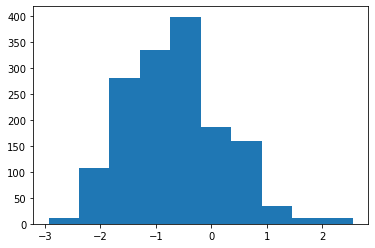


-------------------------------------------------------------------------------

LeakyReLU
torch.Size([2, 3, 256])
% > 0: 0.201171875


,quantiles
0.0,-0.029345
0.1,-0.017366
0.2,-0.014344
0.3,-0.011804
0.4,-0.009389
0.5,-0.006933
0.6,-0.005022
0.7,-0.002689
0.8,0.006336
0.9,0.507812


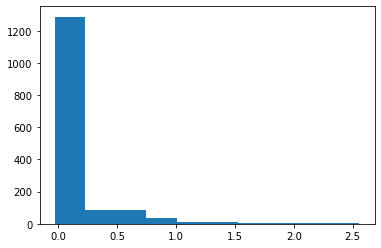


-------------------------------------------------------------------------------

Linear
torch.Size([2, 3, 1])
% > 0: 1.0


,quantiles
0.0,0.596447
0.1,0.625609
0.2,0.654771
0.3,0.666802
0.4,0.678833
0.5,0.679329
0.6,0.679825
0.7,0.692234
0.8,0.704644
0.9,0.714958


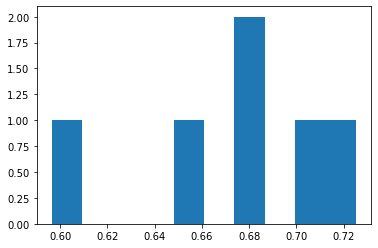


-------------------------------------------------------------------------------



In [43]:
for layer in t.net.head.fc_stack:
    print(type(layer).__name__)
    act = layer(act)
    summarize_acts(act)
    print(spacer())

In [44]:
t.predict(*xb, logits=True)

tensor([[0.5964, 0.7253, 0.6798],
        [0.6788, 0.6548, 0.7046]])

In [45]:
yb

tensor([[0., 1., 1.],
        [0., 1., 1.]])

In [48]:
t.net.head.fc_stack[-1].bias

Parameter containing:
tensor([-0.0237], requires_grad=True)

(array([13., 22., 31., 20., 50., 33., 26., 37., 19.,  5.]),
 array([-0.06262898, -0.04938013, -0.03613127, -0.02288242, -0.00963357,
         0.00361529,  0.01686415,  0.030113  ,  0.04336185,  0.05661071,
         0.06985956], dtype=float32),
 <a list of 10 Patch objects>)

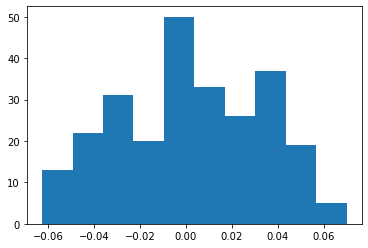

In [51]:
plt.hist(t.net.head.fc_stack[-1].weight.detach().numpy().flatten())

## Callback to track gradients

In [25]:
from collections import defaultdict

from incendio.callbacks import TorchCallback, CometCallback

In [26]:
class CometCallbackWithGrads(CometCallback):
    
    def on_train_begin(self, trainer, epochs, lrs, lr_mult, **kwargs):
        super().on_train_begin(trainer, epochs, lrs, lr_mult, **kwargs)
        self.means = defaultdict(list)
        self.stds = defaultdict(list)

    def after_backward(self, trainer, i, sum_i):
        for name, weights in trainer.net.named_parameters():
            if 'bias' in name or not weights.requires_grad:
                continue
            abs_grads = np.abs(weights.grad.detach().numpy())
            self.means[name].append(abs_grads.mean())
            self.stds[name].append(abs_grads.std())
        
    def on_train_end(self, trainer, epoch, val_stats):
        fig, ax = plt.subplots(figsize=(10, 6))
        plt.bar(range(len(self.means)), 
                [np.mean(v) for v in self.means.values()], 
                yerr=[np.mean(v) for v in self.stds.values()],
                align='edge', alpha=.7)
        plt.xticks(range(len(self.means)), 
                   labels=[''.join(k.split('.')[:-1]) 
                           for k in self.means.keys()],
                   rotation=60)
        plt.tight_layout()
        self.exp.log_figure('grad_avg', fig)
        super().on_train_end(trainer, epoch, val_stats)

## Incendio - Unsupervised Mixup Dataset (regression)

In [208]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup', mode='mixup', 
                                   bs=2, train_pct=.5, max_train_len=6,
                                   max_val_len=6, regression=True)
lmap(len, dst, dsv, dlt, dlv)

[4, 4, 2, 2]

In [209]:
*x, y = dst[0]
smap(*x, y)

[torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 torch.Size([3])]

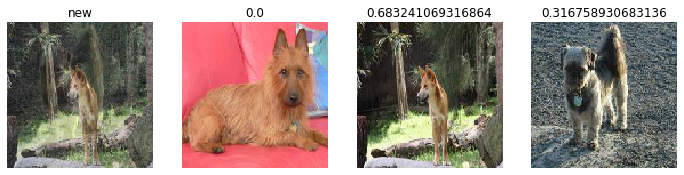

In [210]:
show_images(x, titles=['new']+y.tolist())

In [211]:
*xb, yb = next(iter(dlt))
smap(*xb, yb)

[torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3, 128, 128]),
 torch.Size([2, 3])]

In [274]:
# net = Unmixer(
#     Encoder(fs=(8, 64, 512), strides=(2, 2, 2), act=nn.LeakyReLU()),
#     MLPHead(1024, (512, 128, 1), act=nn.LeakyReLU(), batch_norm=False, post_mult_batch_norm=True, last_act=None)
# )

# net = Unmixer(
#     Encoder(fs=(256,), strides=(2,), act=nn.LeakyReLU()),
#     MLPHead(512, (1,), act=nn.LeakyReLU(), batch_norm=False, post_mult_batch_norm=True, last_act=None)
# )

net = Unmixer(
    Encoder(fs=(256,), strides=(2,), act=nn.LeakyReLU()),
    head=SimilarityHead(last_act='sigmoid')
)

In [275]:
net

Unmixer(
  (encoder): Encoder(
    (conv): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
    )
  )
  (pool): PoolFlatten(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
  )
  (head): SimilarityHead(
    (similarity): CosineSimilarity()
  )
)

In [276]:
net(*xb)

tensor([[0.7275, 0.7240, 0.7221],
        [0.7250, 0.7259, 0.7263]], grad_fn=<SigmoidBackward>)

2020-08-30 20:54:00,105 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/hdmamin/img-wang/1948488d517f44f0b34dc44331ce77f7





=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8159 |       0.8160 |





=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8101 |       0.8145 |





=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8214 |       0.8700 |





=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8397 |       0.8234 |





=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8213 |       0.8090 |





=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.8134 |       0.8043 |


Training complete. Model in eval mode.


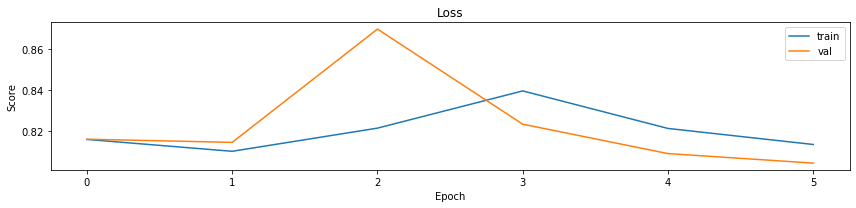

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/hdmamin/img-wang/1948488d517f44f0b34dc44331ce77f7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [6] : (0.8100888133049011, 0.8396753072738647)
COMET INFO:     val_loss [6]   : (0.8043077886104584, 0.8699540495872498)
COMET INFO:   Parameters:
COMET INFO:     _stop_training : 1
COMET INFO:     epochs         : 6
COMET INFO:     eps            : 0.001
COMET INFO:     lr_mult        : 1.0
COMET INFO:     lrs            : 0.003
COMET INFO:     mode           : regression
COMET INFO:     out_dir        : data/models/v0
COMET INFO:     thresh         : 0.5
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (50 KB)
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 1
COMET INFO:

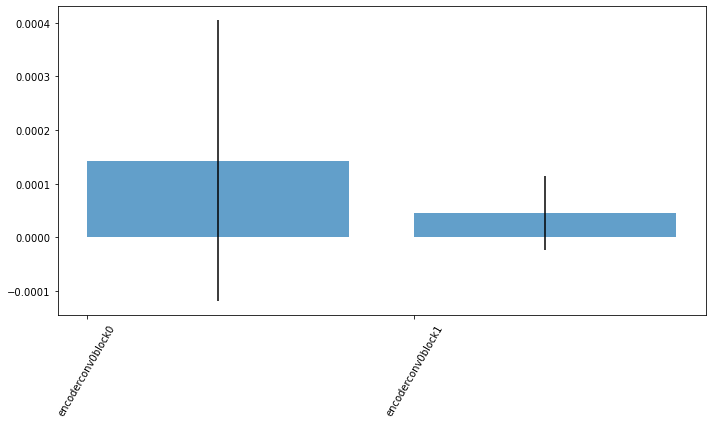

In [277]:
t = Trainer(net, dst, dsv, dlt, dlv, PairwiseLossReduction(),
            'regression', 'data/models/v0', last_act=None,
            callbacks=[MetricHistory(None, None), 
                       CometCallbackWithGrads('img_wang')])
t.fit(6)

In [266]:
cb.means

defaultdict(list,
            {'encoder.conv.0.block.0.weight': [0.060301226,
              0.07963175,
              0.039287947,
              0.03935874,
              0.027617522,
              0.0059808376],
             'encoder.conv.0.block.1.weight': [0.027564391,
              0.04987465,
              0.028311728,
              0.029664906,
              0.016965616,
              0.0016328194],
             'encoder.conv.1.block.0.weight': [0.016008744,
              0.023454484,
              0.009106936,
              0.010007722,
              0.0064260517,
              0.0015681884],
             'encoder.conv.1.block.1.weight': [0.005713595,
              0.013368829,
              0.005574143,
              0.0054572425,
              0.0045125326,
              0.0008675963],
             'encoder.conv.2.block.0.weight': [0.003441962,
              0.004918997,
              0.0019023253,
              0.0018689712,
              0.0010716966,
              0.0003475

In [267]:
cb.stds

defaultdict(list,
            {'encoder.conv.0.block.0.weight': [0.08470082,
              0.07901203,
              0.038001776,
              0.03594064,
              0.037255608,
              0.0066996906],
             'encoder.conv.0.block.1.weight': [0.015105727,
              0.0405376,
              0.018588623,
              0.016632166,
              0.013225363,
              0.0009194485],
             'encoder.conv.1.block.0.weight': [0.014653008,
              0.021828905,
              0.007938808,
              0.009796026,
              0.0065471553,
              0.0017158542],
             'encoder.conv.1.block.1.weight': [0.0042985976,
              0.011879263,
              0.004098256,
              0.0044479854,
              0.0035545216,
              0.0006466846],
             'encoder.conv.2.block.0.weight': [0.004562702,
              0.006994755,
              0.002530606,
              0.002987005,
              0.0020111192,
              0.0006820513

In [268]:
t.net.encoder.conv[0].block[0].weight.grad.abs().mean()

tensor(0.0048)

In [269]:
t.net.encoder.conv[0].block[1].weight.grad.abs().mean()

tensor(0.0049)

In [270]:
t.net.encoder.conv[1].block[0].weight.grad.abs().mean()

tensor(0.0035)

No handles with labels found to put in legend.


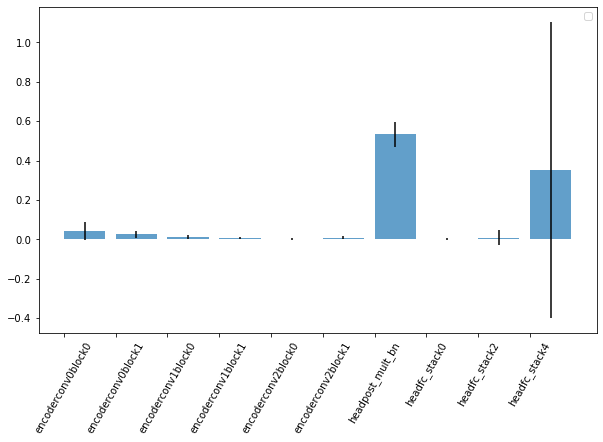

In [127]:
cb = t.callbacks['CometCallbackWithGrads']
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(range(len(cb.means)), 
        [np.mean(v) for v in cb.means.values()], 
        yerr=[np.mean(v) for v in cb.stds.values()],
        align='edge', alpha=.7)
plt.xticks(range(len(cb.means)), 
           labels=[''.join(k.split('.')[:-1]) for k in cb.means.keys()],
           rotation=60)
plt.legend()
plt.show()

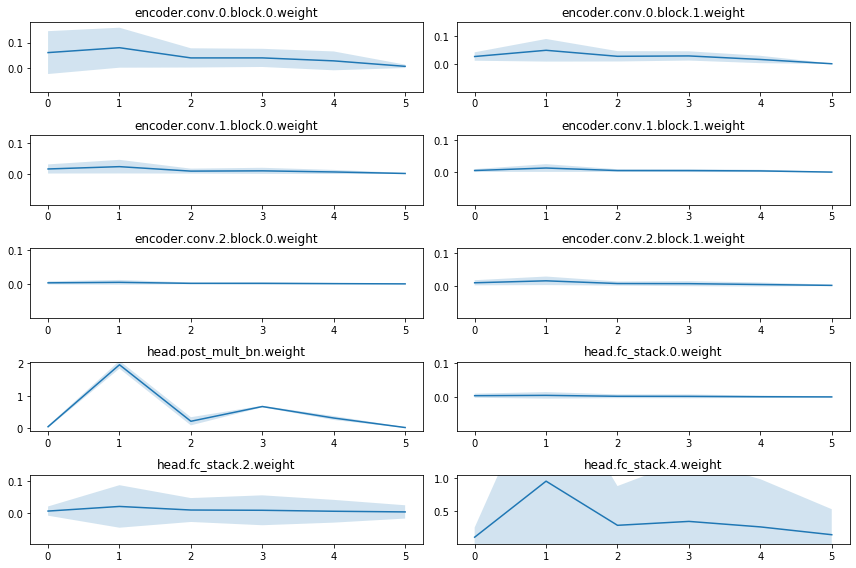

In [123]:
cb = t.callbacks['CometCallbackWithGrads']
fig, ax = plt.subplots(len(cb.means) // 2, 2, figsize=(12, 8))
for axi, (k, v) in zip(ax.flatten(), cb.means.items()):
    v = np.array(v)
    stds = np.array(cb.stds[k])
    axi.plot(v, label=k)
    axi.fill_between(range(len(v)), v + stds, v - stds, alpha=.2)
    axi.set_ylim(min(v) - .1, max(v) + .1)
    axi.set_title(k)
plt.tight_layout()
plt.show()

In [278]:
t.predict(*xb, logits=False)

tensor([[0.7280, 0.7265, 0.7267],
        [0.7265, 0.7210, 0.7225]])

In [279]:
t.predict(*xb, logits=True)

tensor([[0.7280, 0.7265, 0.7267],
        [0.7265, 0.7210, 0.7225]])

In [280]:
yb

tensor([[0.5859, 0.0000, 0.4141],
        [0.4800, 0.0000, 0.5200]])

torch.Size([2, 512, 15, 15])
% > 0: 0.47019965277777775


,quantiles
0.0,-0.055663
0.1,-0.009656
0.2,-0.007663
0.3,-0.006039
0.4,-0.003730
0.5,-0.000888
0.6,0.220189
0.7,0.538774
0.8,0.773970
0.9,1.058257


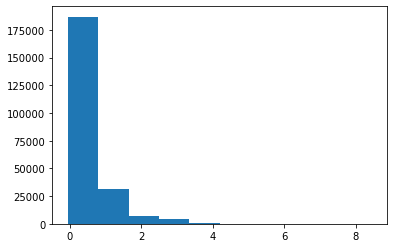

In [88]:
acts = t.net.encoder.predict(xb[0])
summarize_acts(acts)

## Scratch

In [93]:
for n, w in net.named_parameters():
    print(n, w.shape, w.requires_grad)

encoder.conv.0.block.0.weight torch.Size([8, 3, 3, 3]) True
encoder.conv.0.block.1.weight torch.Size([8]) True
encoder.conv.0.block.1.bias torch.Size([8]) True
encoder.conv.1.block.0.weight torch.Size([64, 8, 3, 3]) True
encoder.conv.1.block.1.weight torch.Size([64]) True
encoder.conv.1.block.1.bias torch.Size([64]) True
encoder.conv.2.block.0.weight torch.Size([512, 64, 3, 3]) True
encoder.conv.2.block.1.weight torch.Size([512]) True
encoder.conv.2.block.1.bias torch.Size([512]) True
head.post_mult_bn.weight torch.Size([3]) True
head.post_mult_bn.bias torch.Size([3]) True
head.fc_stack.0.weight torch.Size([512, 1024]) True
head.fc_stack.0.bias torch.Size([512]) True
head.fc_stack.2.weight torch.Size([128, 512]) True
head.fc_stack.2.bias torch.Size([128]) True
head.fc_stack.4.weight torch.Size([1, 128]) True
head.fc_stack.4.bias torch.Size([1]) True


Wanted to figure out a way to make a cached property that accepts arguments but I think this would require a totally different implementation than what I've built in htools. I guess `__get__` doesn't receive args or kwargs because it's intended for attribute access.

In [146]:
class set_once:
    
    def __init__(self, func):
        self.func = func

    def __get__(self, instance, cls, *args, **kwargs):
        """This method is called when the variable being accessed is not in the
        instance's state dict. The next time the attribute is accessed, the
        computed value will be in the state dict so this method (and the method
        in the instance itself) is not called again unless the attribute is
        deleted.
        """
        print(args, kwargs)
        # When attribute accessed as class method, instance is None.
        if instance is None:
            return self

        # When accessed as instance method, call method on instance as usual.
        # Then set instance attribute and return value.
        val = self.func(instance, *args, **kwargs)
        setattr(instance, self.func.__name__, val)
        return val

In [150]:
class Foo:
    
    def __init__(self, a=None):
        self.a = a
        
    @set_once
    def dim(self, x):
        print('calling dim function')
        return len(x) // 2
    
    def __call__(self, x):
        try:
            dim = self.dim
        except:
            print('except')
            dim = self.dim(x)
        return x / dim

In [151]:
f = Foo(3)

In [152]:
f(np.arange(4))

() {}
except
() {}


TypeError: dim() missing 1 required positional argument: 'x'